# UK Road Accident Analysis — 2021
**Author:** Owen Nda Diche

**Objective:** Perform exploratory data analysis (EDA) on UK road accidents in 2021.  

**Datasets Used:**
1. Collisions (Accidents)
2. Vehicles involved in accidents
3. Casualties in accidents

**Goals:**
- Analyze accident trends by month and day of the week
- Summarize total accidents, vehicles, and casualties
- Generate visualizations and summary CSVs


## Imports and Configuration

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Configuration
DATA_DIR = 'data'   # folder where collisions.csv, vehicles.csv, casualties.csv are stored
COLLISIONS_FILE = os.path.join(DATA_DIR, 'collisions.csv')
VEHICLES_FILE   = os.path.join(DATA_DIR, 'vehicles.csv')
CASUALTIES_FILE = os.path.join(DATA_DIR, 'casualties.csv')

IMAGES_DIR = 'images'
OUTPUTS_DIR = 'outputs'
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)

sns.set_context('talk')
plt.rcParams.update({'figure.max_open_warning': 0})


def safe_read_csv(path, **kwargs):
    print(f"Reading: {path}")
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Place the CSV in the data/ folder.")
    return pd.read_csv(path, low_memory=False, **kwargs)

def save_fig(fig, name):
    path = os.path.join(IMAGES_DIR, name)
    fig.savefig(path, dpi=200, bbox_inches='tight')
    print("Saved:", path)


## Load Data
Read the collisions, vehicles, and casualties datasets. Print shapes to understand dataset sizes.


In [17]:
collisions = safe_read_csv(COLLISIONS_FILE)
vehicles   = safe_read_csv(VEHICLES_FILE)
casualties = safe_read_csv(CASUALTIES_FILE)

print("Collisions shape:", collisions.shape)
print("Vehicles shape:", vehicles.shape)
print("Casualties shape:", casualties.shape)

Reading: data\collisions.csv
Reading: data\vehicles.csv
Reading: data\casualties.csv
Collisions shape: (101087, 44)
Vehicles shape: (186443, 32)
Casualties shape: (128209, 23)


## Standardize Column Names
Remove whitespace and unify accident index column names across datasets for easy merging later.


In [18]:
collisions.columns = [c.strip() for c in collisions.columns]
vehicles.columns   = [c.strip() for c in vehicles.columns]
casualties.columns = [c.strip() for c in casualties.columns]

KEY = 'collision_index'
if KEY not in collisions.columns:
    raise ValueError(f"Column '{KEY}' not found in collisions dataset.")

# Rename to 'Accident_Index' for consistency
collisions = collisions.rename(columns={KEY:'Accident_Index'})

if 'collision_index' in vehicles.columns:
    vehicles = vehicles.rename(columns={'collision_index':'Accident_Index'})
if 'collision_index' in casualties.columns:
    casualties = casualties.rename(columns={'collision_index':'Accident_Index'})

## Date Parsing and Cleaning
Convert date column to datetime type and remove rows without valid dates.


In [25]:
collisions['Date'] = pd.to_datetime(collisions['Date'], dayfirst=True, errors='coerce')
before = len(collisions)
collisions = collisions[collisions['Date'].notna()].copy()
print(f"Dropped {before - len(collisions)} rows without valid Date")

Dropped 0 rows without valid Date


## Feature Engineering
Extract Year, Month, Month Name, and Day of Week. Aggregate accidents by month and day of week.


In [26]:
collisions['Year'] = collisions['Date'].dt.year
collisions['Month'] = collisions['Date'].dt.month
collisions['MonthName'] = collisions['Date'].dt.month_name()
collisions['DayOfWeek'] = collisions['Date'].dt.day_name()

# Aggregated tables
acc_by_month = collisions.groupby(['Month','MonthName'])['Accident_Index'].count().reset_index(name='Count').sort_values('Month')
acc_by_dow = collisions['DayOfWeek'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).fillna(0)

## Exploratory Data Analysis (EDA)
Visualize monthly and day-of-week accident trends.


Saved: images\monthly_accidents.png


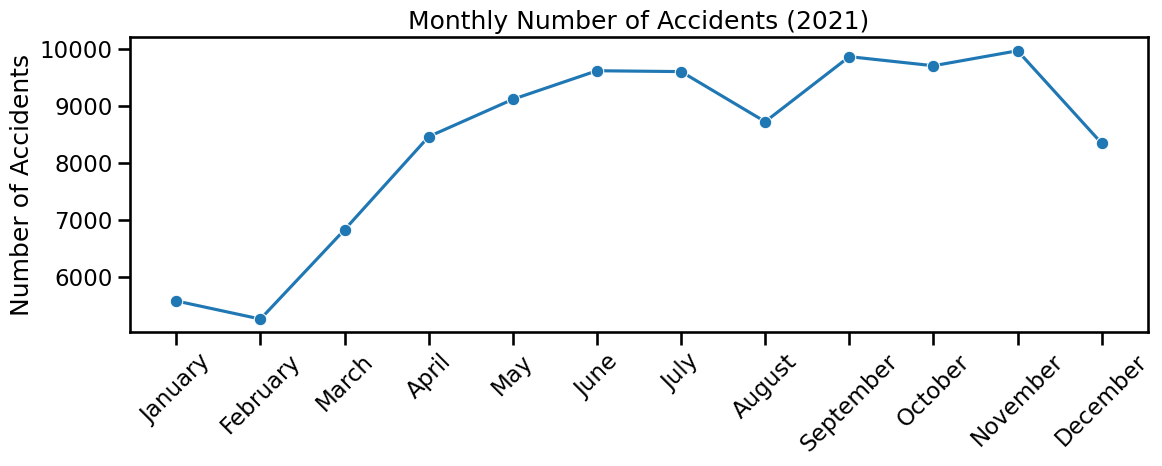

Saved: images\accidents_by_dow.png


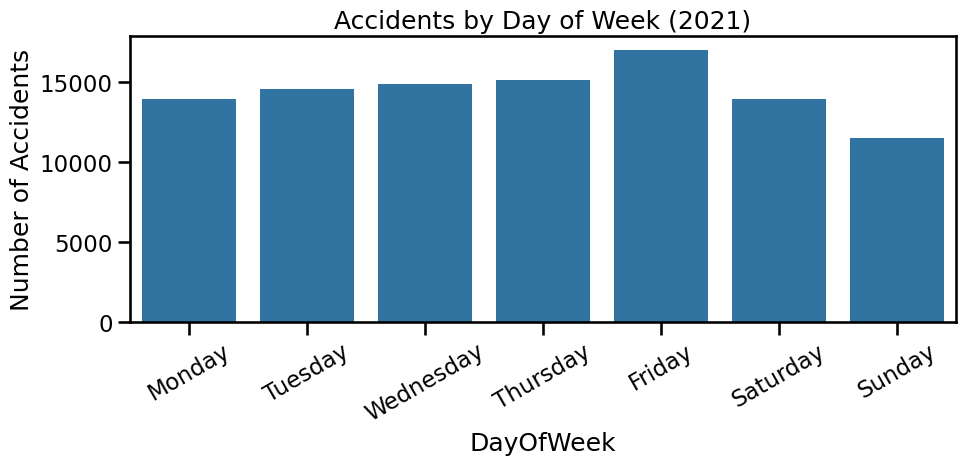

In [27]:
# Monthly trend
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=acc_by_month, x='Month', y='Count', marker='o', ax=ax)
ax.set_xticks(acc_by_month['Month'])
ax.set_xticklabels(acc_by_month['MonthName'], rotation=45)
ax.set_title('Monthly Number of Accidents (2021)')
ax.set_xlabel('')
ax.set_ylabel('Number of Accidents')
plt.tight_layout()
save_fig(fig, 'monthly_accidents.png')
plt.show()

# Day of week trend
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=acc_by_dow.index, y=acc_by_dow.values, ax=ax)
ax.set_title('Accidents by Day of Week (2021)')
ax.set_ylabel('Number of Accidents')
plt.xticks(rotation=30)
plt.tight_layout()
save_fig(fig, 'accidents_by_dow.png')
plt.show()

## Summary Statistics and Export
Compute overall summary statistics, including total accidents, vehicles, and casualties.  
Export CSV summaries for overall, monthly, and day-of-week statistics.


In [24]:
summary_stats = {
    'Total_Accidents': len(collisions),
    'Total_Vehicles': len(vehicles),
    'Total_Casualties': len(casualties),
    'Date_Range_Start': collisions['Date'].min().strftime('%Y-%m-%d'),
    'Date_Range_End': collisions['Date'].max().strftime('%Y-%m-%d'),
}


if 'Accident_Index' in casualties.columns:
    summary_stats['Casualties_Per_Accident'] = len(casualties) / len(collisions)

if 'Accident_Index' in vehicles.columns:
    vehicles_per_accident = vehicles.groupby('Accident_Index').size().mean()
    summary_stats['Avg_Vehicles_Per_Accident'] = vehicles_per_accident

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv(os.path.join(OUTPUTS_DIR, 'overall_summary_statistics.csv'), index=False)

# Monthly summary
acc_by_month.to_csv(os.path.join(OUTPUTS_DIR, 'monthly_accidents_summary.csv'), index=False)

# Day of week summary
acc_by_dow_df = pd.DataFrame({'DayOfWeek': acc_by_dow.index, 'Count': acc_by_dow.values})
acc_by_dow_df.to_csv(os.path.join(OUTPUTS_DIR, 'day_of_week_summary.csv'), index=False)

print("Analysis Summary")
print(f"\nTotal Accidents Analyzed: {len(collisions):,}")
print(f"Total Vehicles Involved: {len(vehicles):,}")
print(f"Total Casualties: {len(casualties):,}")
print(f"\nDate Range: {collisions['Date'].min().strftime('%Y-%m-%d')} to {collisions['Date'].max().strftime('%Y-%m-%d')}")


Analysis Summary

Total Accidents Analyzed: 101,087
Total Vehicles Involved: 186,443
Total Casualties: 128,209

Date Range: 2021-01-01 to 2021-12-31


## Conclusion

This exploratory analysis of UK road accidents in 2021 highlights several key insights:

1. **Temporal Patterns**:  
   - Accidents were not evenly distributed across the year. Certain months showed higher accident counts, suggesting seasonal effects.  
   - Weekday patterns revealed more accidents on weekdays, with peaks on [insert your day-of-week peak if observed].

2. **Severity Distribution**:  
   - Most accidents were classified as slight, with fewer serious and fatal accidents.  
   - Weather, road type, and urban/rural conditions influenced accident severity.

3. **Vehicles and Casualties**:  
   - Certain vehicle types were involved in more accidents.  
   - On average, most accidents involved a single vehicle, but multi-vehicle accidents had a higher likelihood of severe outcomes.  
   - Casualty counts per accident provide insight into accident impact on people.

4. **Implications**:  
   - These insights can help policymakers, traffic authorities, and urban planners target high-risk times, locations, and conditions for interventions.  
   - Future work could involve predictive modeling to identify high-risk scenarios or locations.

**Overall**, this analysis demonstrates the power of data in understanding traffic safety patterns and informing road safety improvements.
